In [5]:
import ast
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import tensorflow as tf

import glob
import imageio
import matplotlib.pyplot as plt
import os
import PIL
from tensorflow.keras import layers
import time

import pylab as plt2

import cv2
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from pyts.image import RecurrencePlot
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LogisticRegression

mms = MinMaxScaler()

# 1. 모델 학습 및 테스트

### 1-1) Dtw로 분류한 정상 데이터(변수Reamer = Good_reamers.csv)로 train 데이터 생성

In [2]:
REAMER = pd.read_csv('Good_reamers.csv')

#### SrcData의 type을 str to list 변경

In [6]:
for i in range(len(REAMER)):
    REAMER.srcData[i] = ast.literal_eval(REAMER.srcData[i])

<ipython-input-6-8a7ccb8a8944>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  REAMER.srcData[i] = ast.literal_eval(REAMER.srcData[i])


#### list to numpy.array

In [7]:
data = dict(REAMER.srcData)
data_array = np.array(list(data.values()), dtype = object)
data_array

array([[1161, 1150, 1199, ..., 1507, 1335, 1174],
       [1161, 1156, 1210, ..., 1618, 1410, 1216],
       [1261, 1170, 1153, ..., 1587, 1437, 1265],
       ...,
       [1057, 1047, 1093, ..., 1563, 1384, 1198],
       [1076, 1048, 1082, ..., 1577, 1402, 1219],
       [1060, 1059, 1113, ..., 1557, 1374, 1192]], dtype=object)

#### MinMaxScaler() 사용하여 0~1 scaling하기

In [10]:
data = mms.fit_transform(data_array.reshape(len(data), 407))
data

array([[0.22057264, 0.30809859, 0.51594203, ..., 0.183391  , 0.1821366 ,
        0.20445344],
       [0.22057264, 0.31866197, 0.54782609, ..., 0.37543253, 0.31348511,
        0.28947368],
       [0.32661718, 0.34330986, 0.3826087 , ..., 0.32179931, 0.36077058,
        0.38866397],
       ...,
       [0.11028632, 0.12676056, 0.20869565, ..., 0.28027682, 0.26795096,
        0.25303644],
       [0.13043478, 0.12852113, 0.17681159, ..., 0.30449827, 0.29947461,
        0.29554656],
       [0.11346766, 0.14788732, 0.26666667, ..., 0.26989619, 0.25043783,
        0.24089069]])

### (실행x)

실제로는 모델을 학습시키기 전 train과 test로 일정 비율로 split한 후, train data 중 정상 데이터만을 dtw로 뽑아낸 후 학습시켜야 한다. 하지만 현재 받은 파일은 전체 data를 대상으로 정상 데이터를 뽑아냈기에 학습 data수가 더 많다. 따라서, 최종본의 데이터 수에 맞춰 최적의 parameter를 뽑아내기 위해 현재 뽑아낸 정상 데이터를 진행 순서를 바꿔 split후 학습시키겠다.

In [11]:
data.shape

(20675, 407)

In [14]:
train, Useless = train_test_split(data, test_size=0.4)

In [15]:
train.shape

(12405, 407)

## 1-2) train데이터로 Recurrence plot 적용하여 학습

In [16]:
from pyts.image import RecurrencePlot

transformer = RecurrencePlot(
                dimension=1,
                time_delay=1,
                threshold='point',
                percentage=10,
                flatten=False )

### a) Flatten 버전

#### train 데이터(변수 : train / 실제론 dtw를 적용한 dataset을 활용)를 recurrenc plot으로 이미지화 

In [17]:
RC = []
for i in range(len(train)//100):
    SlicingSet = transformer.transform(train[100*i:100*(i+1)]).astype('float32')
    for j in range(100):
        resized_image = cv2.resize(SlicingSet[j],(100, 100), interpolation=cv2.INTER_AREA)
        RC.append(resized_image)

SlicingSet = transformer.transform(train[-(len(train)%100):]).astype('float32')
for k in range(len(train)%100):
    resized_image = cv2.resize(SlicingSet[k],(100, 100), interpolation=cv2.INTER_AREA)
    RC.append(resized_image)
    
RC = np.array(RC)

#### train 데이터를 통해 AutoEncoder를 학습

In [18]:
RC = RC.reshape((RC.shape[0],100*100))

scaler = MinMaxScaler()
scaler.fit(RC)
RC_train_scaled=scaler.transform(RC)

train_imgs = RC_train_scaled
n_train1 = train_imgs.shape[0]


# Define Structure

# Encoder Structure
encoder1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2000, activation = 'relu', input_shape = (100*100,)),
    tf.keras.layers.Dense(1200, activation = 'relu'),
    tf.keras.layers.Dense(20, activation = None)
    ])

# Decoder Structure
decoder1 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1200, activation = 'relu', input_shape = (20,)),
    tf.keras.layers.Dense(2000, activation = 'relu'),
    tf.keras.layers.Dense(100*100, activation = None)
    ])

# Autoencoder = Encoder + Decoder
autoencoder1 = tf.keras.models.Sequential([encoder1, decoder1])

autoencoder1.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                    loss = 'mean_squared_error',
                    metrics = ['mse'])

# Train Model & Evaluate Test Data

training1 = autoencoder1.fit(train_imgs, train_imgs, batch_size = 50, epochs = 10)

Epoch 1/10
249/249 [==============================] - 52s 208ms/step - loss: 0.0166 - mse: 0.0166
Epoch 2/10
249/249 [==============================] - 56s 224ms/step - loss: 0.0132 - mse: 0.0132
Epoch 3/10
249/249 [==============================] - 57s 230ms/step - loss: 0.0121 - mse: 0.0121
Epoch 4/10
249/249 [==============================] - 68s 272ms/step - loss: 0.0115 - mse: 0.0115
Epoch 5/10
249/249 [==============================] - 73s 292ms/step - loss: 0.0111 - mse: 0.0111
Epoch 6/10
249/249 [==============================] - 72s 289ms/step - loss: 0.0108 - mse: 0.0108
Epoch 7/10
249/249 [==============================] - 73s 292ms/step - loss: 0.0105 - mse: 0.0105
Epoch 8/10
249/249 [==============================] - 75s 302ms/step - loss: 0.0103 - mse: 0.0103
Epoch 9/10
249/249 [==============================] - 74s 296ms/step - loss: 0.0101 - mse: 0.0101
Epoch 10/10
249/249 [==============================] - 80s 322ms/step - loss: 0.0100 - mse: 0.0100


#### test 데이터(변수 : Useless / 실제론 dtw를 적용하지 않은 dataset을 활용)를 recurrenc plot으로 이미지화

In [19]:
RC2 = []
for i in range(len(Useless)//100):
    SlicingSet = transformer.transform(Useless[100*i:100*(i+1)]).astype('float32')
    for j in range(100):
        resized_image = cv2.resize(SlicingSet[j],(100, 100), interpolation=cv2.INTER_AREA)
        RC2.append(resized_image)

SlicingSet = transformer.transform(Useless[-(len(Useless)%100):]).astype('float32')
for k in range(len(Useless)%100):
    resized_image = cv2.resize(SlicingSet[k],(100, 100), interpolation=cv2.INTER_AREA)
    RC2.append(resized_image)
    
RC2 = np.array(RC2)

In [20]:
RC2 = RC2.reshape((RC2.shape[0],100*100))

scaler = MinMaxScaler()
scaler.fit(RC2)
RC_test_scaled=scaler.transform(RC2)

test_imgs = RC_test_scaled
n_test1 = test_imgs.shape[0]

#### hyperparameter찾기

#### 1) 10000 -> 2000 -> 1200 -> 20 -> 1200 -> 2000 -> 10000

In [22]:
test_scores1 = autoencoder1.evaluate(test_imgs, test_imgs, verbose = 2)
print('Test loss: {}'.format(test_scores1[0]))
print('Mean Squared Error: {} %'.format(test_scores1[1]*100))

259/259 - 8s - loss: 0.0116 - mse: 0.0116
Test loss: 0.011552037671208382
Mean Squared Error: 1.1552037671208382 %


In [23]:
test_imgs.shape

(8270, 10000)

# 

#### 2) 10000 -> 5000 -> 2500 -> 20 -> 2500 -> 5000 -> 10000

In [26]:
encoder1_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(5000, activation = 'relu', input_shape = (100*100,)),
    tf.keras.layers.Dense(2500, activation = 'relu'),
    tf.keras.layers.Dense(20, activation = None)
    ])

# Decoder Structure
decoder1_2 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(2500, activation = 'relu', input_shape = (20,)),
    tf.keras.layers.Dense(5000, activation = 'relu'),
    tf.keras.layers.Dense(100*100, activation = None)
    ])

# Autoencoder = Encoder + Decoder
autoencoder1_2 = tf.keras.models.Sequential([encoder1_2, decoder1_2])

autoencoder1_2.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                    loss = 'mean_squared_error',
                    metrics = ['mse'])

# Train Model & Evaluate Test Data

training1_2 = autoencoder1_2.fit(train_imgs, train_imgs, batch_size = 50, epochs = 10)

Epoch 1/10
249/249 [==============================] - 136s 548ms/step - loss: 0.0168 - mse: 0.0168
Epoch 2/10
249/249 [==============================] - 182s 732ms/step - loss: 0.0136 - mse: 0.0136
Epoch 3/10
249/249 [==============================] - 213s 854ms/step - loss: 0.0123 - mse: 0.0123
Epoch 4/10
249/249 [==============================] - 197s 792ms/step - loss: 0.0116 - mse: 0.0116
Epoch 5/10
249/249 [==============================] - 208s 834ms/step - loss: 0.0111 - mse: 0.0111
Epoch 6/10
249/249 [==============================] - 215s 862ms/step - loss: 0.0108 - mse: 0.0108
Epoch 7/10
249/249 [==============================] - 204s 818ms/step - loss: 0.0105 - mse: 0.0105
Epoch 8/10
249/249 [==============================] - 190s 763ms/step - loss: 0.0103 - mse: 0.0103
Epoch 9/10
249/249 [==============================] - 201s 808ms/step - loss: 0.0101 - mse: 0.0101
Epoch 10/10
249/249 [==============================] - 250s 1s/step - loss: 0.0099 - mse: 0.0099


In [29]:
test_scores1_2 = autoencoder1_2.evaluate(test_imgs, test_imgs, verbose = 2)
print('Test loss: {}'.format(test_scores1_2[0]))
print('Mean Squared Error: {} %'.format(test_scores1_2[1]*100))

259/259 - 18s - loss: 0.0114 - mse: 0.0114
Test loss: 0.01142728142440319
Mean Squared Error: 1.142728142440319 %


# 

#### 3) 10000 -> 1000 -> 100 -> 2 -> 100 -> 1000 -> 10000

In [28]:
encoder1_3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1000, activation = 'relu', input_shape = (100*100,)),
    tf.keras.layers.Dense(100, activation = 'relu'),
    tf.keras.layers.Dense(2, activation = None)
    ])

# Decoder Structure
decoder1_3 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(100, activation = 'relu', input_shape = (2,)),
    tf.keras.layers.Dense(1000, activation = 'relu'),
    tf.keras.layers.Dense(100*100, activation = None)
    ])

# Autoencoder = Encoder + Decoder
autoencoder1_3 = tf.keras.models.Sequential([encoder1_3, decoder1_3])

autoencoder1_3.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                    loss = 'mean_squared_error',
                    metrics = ['mse'])

# Train Model & Evaluate Test Data

training1_3 = autoencoder1_3.fit(train_imgs, train_imgs, batch_size = 50, epochs = 10)

Epoch 1/10
249/249 [==============================] - 24s 95ms/step - loss: 0.0174 - mse: 0.0174
Epoch 2/10
249/249 [==============================] - 24s 95ms/step - loss: 0.0162 - mse: 0.0162
Epoch 3/10
249/249 [==============================] - 25s 100ms/step - loss: 0.0157 - mse: 0.0157
Epoch 4/10
249/249 [==============================] - 26s 105ms/step - loss: 0.0154 - mse: 0.0154
Epoch 5/10
249/249 [==============================] - 27s 109ms/step - loss: 0.0153 - mse: 0.0153
Epoch 6/10
249/249 [==============================] - 32s 127ms/step - loss: 0.0151 - mse: 0.0151
Epoch 7/10
249/249 [==============================] - 33s 134ms/step - loss: 0.0150 - mse: 0.0150
Epoch 8/10
249/249 [==============================] - 32s 129ms/step - loss: 0.0149 - mse: 0.0149
Epoch 9/10
249/249 [==============================] - 32s 129ms/step - loss: 0.0148 - mse: 0.0148
Epoch 10/10
249/249 [==============================] - 31s 124ms/step - loss: 0.0147 - mse: 0.0147


In [30]:
test_scores1_3 = autoencoder1_3.evaluate(test_imgs, test_imgs, verbose = 2)
print('Test loss: {}'.format(test_scores1_3[0]))
print('Mean Squared Error: {} %'.format(test_scores1_3[1]*100))

259/259 - 3s - loss: 0.0158 - mse: 0.0158
Test loss: 0.015821438282728195
Mean Squared Error: 1.5821438282728195 %


# 

#### 4) 10000 -> 3000 -> 1000 -> 20 -> 1000 -> 3000 -> 10000

In [31]:
encoder1_4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(3000, activation = 'relu', input_shape = (100*100,)),
    tf.keras.layers.Dense(1000, activation = 'relu'),
    tf.keras.layers.Dense(20, activation = None)
    ])

# Decoder Structure
decoder1_4 = tf.keras.models.Sequential([
    tf.keras.layers.Dense(1000, activation = 'relu', input_shape = (20,)),
    tf.keras.layers.Dense(3000, activation = 'relu'),
    tf.keras.layers.Dense(100*100, activation = None)
    ])

# Autoencoder = Encoder + Decoder
autoencoder1_4 = tf.keras.models.Sequential([encoder1_4, decoder1_4])

autoencoder1_4.compile(optimizer = tf.keras.optimizers.Adam(0.001),
                    loss = 'mean_squared_error',
                    metrics = ['mse'])

# Train Model & Evaluate Test Data

training1_4 = autoencoder1_4.fit(train_imgs, train_imgs, batch_size = 50, epochs = 10)

Epoch 1/10
249/249 [==============================] - 72s 290ms/step - loss: 0.0162 - mse: 0.0162
Epoch 2/10
249/249 [==============================] - 92s 370ms/step - loss: 0.0128 - mse: 0.0128
Epoch 3/10
249/249 [==============================] - 100s 402ms/step - loss: 0.0118 - mse: 0.0118
Epoch 4/10
249/249 [==============================] - 101s 405ms/step - loss: 0.0113 - mse: 0.0113
Epoch 5/10
249/249 [==============================] - 114s 457ms/step - loss: 0.0109 - mse: 0.0109
Epoch 6/10
249/249 [==============================] - 106s 427ms/step - loss: 0.0106 - mse: 0.0106
Epoch 7/10
249/249 [==============================] - 106s 425ms/step - loss: 0.0104 - mse: 0.0104
Epoch 8/10
249/249 [==============================] - 110s 443ms/step - loss: 0.0102 - mse: 0.0102
Epoch 9/10
249/249 [==============================] - 107s 429ms/step - loss: 0.0100 - mse: 0.0100
Epoch 10/10
249/249 [==============================] - 114s 459ms/step - loss: 0.0098 - mse: 0.0098


In [32]:
test_scores1_4 = autoencoder1_4.evaluate(test_imgs, test_imgs, verbose = 2)
print('Test loss: {}'.format(test_scores1_4[0]))
print('Mean Squared Error: {} %'.format(test_scores1_4[1]*100))

259/259 - 10s - loss: 0.0114 - mse: 0.0114
Test loss: 0.011362064629793167
Mean Squared Error: 1.1362064629793167 %


# 

### b) Flatten하지 않고, CNN의 filter를 사용하여 학습

#### train 데이터(변수 : train / 실제론 dtw를 적용한 dataset을 활용)를 recurrenc plot으로 이미지화

In [ ]:
RC = []
for i in range(len(train)//100):
    SlicingSet = transformer.transform(train[100*i:100*(i+1)]).astype('float32')
    for j in range(100):
        resized_image = cv2.resize(SlicingSet[j],(100, 100), interpolation=cv2.INTER_AREA)
        RC.append(resized_image)

SlicingSet = transformer.transform(train[-(len(train)%100):]).astype('float32')
for k in range(len(train)%100):
    resized_image = cv2.resize(SlicingSet[k],(100, 100), interpolation=cv2.INTER_AREA)
    RC.append(resized_image)
    
RC = np.array(RC)

#### test 데이터(변수 : Useless / 실제론 dtw를 적용하지 않은 dataset을 활용)를 recurrenc plot으로 이미지화

In [ ]:
RC2 = []
for i in range(len(Useless)//100):
    SlicingSet = transformer.transform(Useless[100*i:100*(i+1)]).astype('float32')
    for j in range(100):
        resized_image = cv2.resize(SlicingSet[j],(100, 100), interpolation=cv2.INTER_AREA)
        RC2.append(resized_image)

SlicingSet = transformer.transform(Useless[-(len(Useless)%100):]).astype('float32')
for k in range(len(Useless)%100):
    resized_image = cv2.resize(SlicingSet[k],(100, 100), interpolation=cv2.INTER_AREA)
    RC2.append(resized_image)
    
RC2 = np.array(RC2)

#### train데이터와 test데이터 모두 model에 fit하기 위해 reshape

In [35]:
normal_train_x = RC.reshape((RC.shape[0],100,100,1))
abnormal_test_x = RC2.reshape((RC2.shape[0],100,100,1))

In [36]:
normal_train_x.shape

(12405, 100, 100, 1)

In [38]:
abnormal_test_x.shape

(8270, 100, 100, 1)

#### 1) hyper #1

In [88]:
# Encoder

encoder2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, 
                           kernel_size = (3,3), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (100, 100, 1)),
    
    tf.keras.layers.Conv2D(filters = 64, 
                           kernel_size = (3,3), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (50, 50, 32)),
    
    tf.keras.layers.Conv2D(filters = 2, 
                           kernel_size = (7,7),
                           padding = 'VALID',
                           input_shape = (25,25,64))
])

encoder2.summary()

Model: "sequential_33"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_49 (Conv2D)           (None, 50, 50, 32)        320       
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 19, 19, 2)         6274      
Total params: 25,090
Trainable params: 25,090
Non-trainable params: 0
_________________________________________________________________


In [89]:
# Decoder

decoder2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(filters = 64, 
                                    kernel_size = (7,7),
                                    strides = (1,1), 
                                    activation = 'relu',
                                    padding = 'VALID',
                                    input_shape = (19, 19, 2)),

    tf.keras.layers.Conv2DTranspose(filters = 32, 
                                    kernel_size = (3,3),
                                    strides = (2,2), 
                                    activation = 'relu',
                                    padding = 'SAME',
                                    input_shape = (25, 25, 64)),

    tf.keras.layers.Conv2DTranspose(filters = 1, 
                                    kernel_size = (7,7),
                                    strides = (2,2),
                                    padding = 'SAME',
                                    input_shape = (50,50,32))
])

decoder2.summary()

Model: "sequential_34"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_24 (Conv2DT (None, 25, 25, 64)        6336      
_________________________________________________________________
conv2d_transpose_25 (Conv2DT (None, 50, 50, 32)        18464     
_________________________________________________________________
conv2d_transpose_26 (Conv2DT (None, 100, 100, 1)       1569      
Total params: 26,369
Trainable params: 26,369
Non-trainable params: 0
_________________________________________________________________


In [39]:
latent2 = encoder2.output
result2 = decoder2(latent2)

In [40]:
model2 = tf.keras.Model(inputs = encoder2.input, outputs = result2)

In [41]:
model2.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

In [42]:
model2.fit(normal_train_x, normal_train_x, epochs = 10)

Epoch 1/10
388/388 [==============================] - 120s 309ms/step - loss: 0.0120
Epoch 2/10
388/388 [==============================] - 135s 349ms/step - loss: 0.0094
Epoch 3/10
388/388 [==============================] - 144s 371ms/step - loss: 0.0091
Epoch 4/10
388/388 [==============================] - 140s 360ms/step - loss: 0.0089
Epoch 5/10
388/388 [==============================] - 325s 837ms/step - loss: 0.0088
Epoch 6/10
388/388 [==============================] - 181s 466ms/step - loss: 0.0087
Epoch 7/10
388/388 [==============================] - 141s 363ms/step - loss: 0.0087
Epoch 8/10
388/388 [==============================] - 131s 339ms/step - loss: 0.0086
Epoch 9/10
388/388 [==============================] - 134s 345ms/step - loss: 0.0086
Epoch 10/10
388/388 [==============================] - 136s 351ms/step - loss: 0.0085


In [45]:
new_test_scores2 = model2.evaluate(abnormal_test_x, abnormal_test_x)
print('Mean Squared Error: {} %'.format(new_test_scores2*100))

259/259 [==============================] - 25s 95ms/step - loss: 0.0085
Mean Squared Error: 0.8544594049453735 %


#### 2) hyper #2

In [107]:
# Encoder

encoder2_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, 
                           kernel_size = (3,3), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (100, 100, 1)),
    
    tf.keras.layers.Conv2D(filters = 64, 
                           kernel_size = (3,3), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (50, 50, 32)),
    
    tf.keras.layers.Conv2D(filters = 2, 
                           kernel_size = (5,5),
                           padding = 'VALID',
                           input_shape = (25,25,64))
])

encoder2_2.summary()

Model: "sequential_48"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_70 (Conv2D)           (None, 50, 50, 32)        320       
_________________________________________________________________
conv2d_71 (Conv2D)           (None, 25, 25, 64)        18496     
_________________________________________________________________
conv2d_72 (Conv2D)           (None, 21, 21, 2)         3202      
Total params: 22,018
Trainable params: 22,018
Non-trainable params: 0
_________________________________________________________________


In [108]:
# Decoder

decoder2_2 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(filters = 64, 
                                    kernel_size = (5,5),
                                    strides = (1,1), 
                                    activation = 'relu',
                                    padding = 'VALID',
                                    input_shape = (21, 21, 2)),

    tf.keras.layers.Conv2DTranspose(filters = 32, 
                                    kernel_size = (3,3),
                                    strides = (2,2), 
                                    activation = 'relu',
                                    padding = 'SAME',
                                    input_shape = (25, 25, 64)),

    tf.keras.layers.Conv2DTranspose(filters = 1, 
                                    kernel_size = (5,5),
                                    strides = (2,2),
                                    padding = 'SAME',
                                    input_shape = (50,50,32))
])

decoder2_2.summary()

Model: "sequential_49"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_48 (Conv2DT (None, 25, 25, 64)        3264      
_________________________________________________________________
conv2d_transpose_49 (Conv2DT (None, 50, 50, 32)        18464     
_________________________________________________________________
conv2d_transpose_50 (Conv2DT (None, 100, 100, 1)       801       
Total params: 22,529
Trainable params: 22,529
Non-trainable params: 0
_________________________________________________________________


In [109]:
latent2_2 = encoder2_2.output
result2_2 = decoder2_2(latent2_2)

model2_2 = tf.keras.Model(inputs = encoder2_2.input, outputs = result2_2)

model2_2.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

In [110]:
model2_2.fit(normal_train_x, normal_train_x, epochs = 10)

Epoch 1/10
388/388 [==============================] - 59s 151ms/step - loss: 0.0115
Epoch 2/10
388/388 [==============================] - 64s 166ms/step - loss: 0.0091
Epoch 3/10
388/388 [==============================] - 74s 192ms/step - loss: 0.0088
Epoch 4/10
388/388 [==============================] - 72s 185ms/step - loss: 0.0086
Epoch 5/10
388/388 [==============================] - 74s 190ms/step - loss: 0.0085
Epoch 6/10
388/388 [==============================] - 79s 203ms/step - loss: 0.0084
Epoch 7/10
388/388 [==============================] - 73s 188ms/step - loss: 0.0084
Epoch 8/10
388/388 [==============================] - 76s 195ms/step - loss: 0.0083
Epoch 9/10
388/388 [==============================] - 73s 187ms/step - loss: 0.0083
Epoch 10/10
388/388 [==============================] - 74s 190ms/step - loss: 0.00830s - loss: 0.0


In [111]:
new_test_scores2_2 = model2_2.evaluate(abnormal_test_x, abnormal_test_x)
print('Mean Squared Error: {} %'.format(new_test_scores2_2*100))

259/259 [==============================] - 12s 48ms/step - loss: 0.0083
Mean Squared Error: 0.8278666064143181 %


#### 3) hyper #3

In [92]:
# Encoder

encoder2_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, 
                           kernel_size = (5,5), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (100, 100, 1)),
    
    tf.keras.layers.Conv2D(filters = 64, 
                           kernel_size = (5,5), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (50, 50, 32)),
    
    tf.keras.layers.Conv2D(filters = 2, 
                           kernel_size = (10,10),
                           padding = 'VALID',
                           input_shape = (25,25,64))
])

encoder2_3.summary()

Model: "sequential_37"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_55 (Conv2D)           (None, 50, 50, 32)        832       
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 25, 25, 64)        51264     
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 16, 16, 2)         12802     
Total params: 64,898
Trainable params: 64,898
Non-trainable params: 0
_________________________________________________________________


In [93]:
# Decoder

decoder2_3 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(filters = 64, 
                                    kernel_size = (10,10),
                                    strides = (1,1), 
                                    activation = 'relu',
                                    padding = 'VALID',
                                    input_shape = (16, 16, 2)),

    tf.keras.layers.Conv2DTranspose(filters = 32, 
                                    kernel_size = (5,5),
                                    strides = (2,2), 
                                    activation = 'relu',
                                    padding = 'SAME',
                                    input_shape = (25, 25, 64)),

    tf.keras.layers.Conv2DTranspose(filters = 1, 
                                    kernel_size = (5,5),
                                    strides = (2,2),
                                    padding = 'SAME',
                                    input_shape = (50,50,32))
])

decoder2_3.summary()

Model: "sequential_38"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_30 (Conv2DT (None, 25, 25, 64)        12864     
_________________________________________________________________
conv2d_transpose_31 (Conv2DT (None, 50, 50, 32)        51232     
_________________________________________________________________
conv2d_transpose_32 (Conv2DT (None, 100, 100, 1)       801       
Total params: 64,897
Trainable params: 64,897
Non-trainable params: 0
_________________________________________________________________


In [81]:
latent2_3 = encoder2_3.output
result2_3 = decoder2_3(latent2_3)

model2_3 = tf.keras.Model(inputs = encoder2_3.input, outputs = result2_3)

model2_3.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

In [82]:
model2_3.fit(normal_train_x, normal_train_x, epochs = 10)

Epoch 1/10
388/388 [==============================] - 167s 430ms/step - loss: 0.0129
Epoch 2/10
388/388 [==============================] - 189s 486ms/step - loss: 0.0100
Epoch 3/10
388/388 [==============================] - 348s 897ms/step - loss: 0.0096
Epoch 4/10
388/388 [==============================] - 351s 905ms/step - loss: 0.0093
Epoch 5/10
388/388 [==============================] - 334s 860ms/step - loss: 0.0092
Epoch 6/10
388/388 [==============================] - 302s 779ms/step - loss: 0.0091
Epoch 7/10
388/388 [==============================] - 216s 556ms/step - loss: 0.0090
Epoch 8/10
388/388 [==============================] - 216s 556ms/step - loss: 0.0089
Epoch 9/10
388/388 [==============================] - 218s 563ms/step - loss: 0.0089
Epoch 10/10
388/388 [==============================] - 189s 487ms/step - loss: 0.0088


In [83]:
new_test_scores2_3 = model2_3.evaluate(abnormal_test_x, abnormal_test_x)
print('Mean Squared Error: {} %'.format(new_test_scores2_3*100))

259/259 [==============================] - 29s 111ms/step - loss: 0.0088
Mean Squared Error: 0.8810850791633129 %


#### 4) hyper #4

In [103]:
# Encoder

encoder2_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(filters = 32, 
                           kernel_size = (7,7), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (100, 100, 1)),
    
    tf.keras.layers.Conv2D(filters = 64, 
                           kernel_size = (7,7), 
                           strides = (2,2), 
                           activation = 'relu',
                           padding = 'SAME',
                           input_shape = (50, 50, 32)),
    
    tf.keras.layers.Conv2D(filters = 2, 
                           kernel_size = (10,10),
                           padding = 'VALID',
                           input_shape = (25,25,64))
])

encoder2_4.summary()

Model: "sequential_47"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_67 (Conv2D)           (None, 50, 50, 32)        1600      
_________________________________________________________________
conv2d_68 (Conv2D)           (None, 25, 25, 64)        100416    
_________________________________________________________________
conv2d_69 (Conv2D)           (None, 16, 16, 2)         12802     
Total params: 114,818
Trainable params: 114,818
Non-trainable params: 0
_________________________________________________________________


In [102]:
# Decoder

decoder2_4 = tf.keras.models.Sequential([
    tf.keras.layers.Conv2DTranspose(filters = 64, 
                                    kernel_size = (10,10),
                                    strides = (1,1), 
                                    activation = 'relu',
                                    padding = 'VALID',
                                    input_shape = (16, 16, 2)),

    tf.keras.layers.Conv2DTranspose(filters = 32, 
                                    kernel_size = (7,7),
                                    strides = (2,2), 
                                    activation = 'relu',
                                    padding = 'SAME',
                                    input_shape = (25, 25, 64)),

    tf.keras.layers.Conv2DTranspose(filters = 1, 
                                    kernel_size = (7,7),
                                    strides = (2,2),
                                    padding = 'SAME',
                                    input_shape = (58,58,32))
])

decoder2_4.summary()

Model: "sequential_46"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_transpose_45 (Conv2DT (None, 25, 25, 64)        12864     
_________________________________________________________________
conv2d_transpose_46 (Conv2DT (None, 50, 50, 32)        100384    
_________________________________________________________________
conv2d_transpose_47 (Conv2DT (None, 100, 100, 1)       1569      
Total params: 114,817
Trainable params: 114,817
Non-trainable params: 0
_________________________________________________________________


In [104]:
latent2_4 = encoder2_4.output
result2_4 = decoder2_4(latent2_4)

model2_4 = tf.keras.Model(inputs = encoder2_4.input, outputs = result2_4)

model2_4.compile(optimizer = 'adam',
              loss = 'mean_squared_error')

In [105]:
model2_4.fit(normal_train_x, normal_train_x, epochs = 10)

Epoch 1/10
388/388 [==============================] - 238s 612ms/step - loss: 0.0118
Epoch 2/10
388/388 [==============================] - 287s 739ms/step - loss: 0.0096
Epoch 3/10
388/388 [==============================] - 298s 768ms/step - loss: 0.0091
Epoch 4/10
388/388 [==============================] - 298s 768ms/step - loss: 0.0088
Epoch 5/10
388/388 [==============================] - 298s 767ms/step - loss: 0.0087
Epoch 6/10
388/388 [==============================] - 309s 797ms/step - loss: 0.0086
Epoch 7/10
388/388 [==============================] - 312s 804ms/step - loss: 0.0085
Epoch 8/10
388/388 [==============================] - 297s 765ms/step - loss: 0.0085
Epoch 9/10
388/388 [==============================] - 298s 768ms/step - loss: 0.0084
Epoch 10/10
388/388 [==============================] - 297s 765ms/step - loss: 0.0083


In [106]:
new_test_scores2_4 = model2_4.evaluate(abnormal_test_x, abnormal_test_x)
print('Mean Squared Error: {} %'.format(new_test_scores2_4*100))

259/259 [==============================] - 34s 130ms/step - loss: 0.0084
Mean Squared Error: 0.835766177624464 %


# 

## test데이터 하나씩 test(실행x)

##### 1. FLATTEN버전

In [205]:
test_scores1 = autoencoder1.evaluate(test_imgs[0:1], test_imgs[0:1], verbose = 2)

1/1 - 0s - loss: 0.0095 - mse: 0.0095


In [206]:
test_imgs[0:1].shape

(1, 10000)

##### 2. CNN버전

In [47]:
abnormal_test_x.shape

(8270, 100, 100, 1)

In [54]:
abnormal_test_x[0].reshape(-1,100,100,1).shape

(1, 100, 100, 1)

In [57]:
abnormal_input = abnormal_test_x[0].reshape(-1,100,100,1)
ab_recon_err = model.evaluate(abnormal_input, abnormal_input)

1/1 [==============================] - 0s 2ms/step - loss: 0.0077


# 

# 3. 이미지 복원

1) Flatten버전

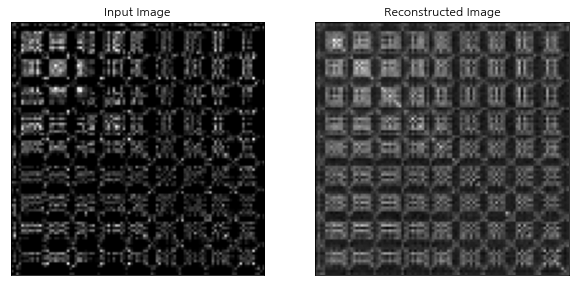

In [151]:
# Visualize Evaluation on Test Data

rand_idx = np.random.randint(1, test_imgs.shape[0])
# rand_idx = 6

test_img = test_imgs[4124]
reconst_img = autoencoder1.predict(test_img.reshape(1,100*100))

plt.figure(figsize = (10, 8))
plt.subplot(1,2,1)
plt.imshow(test_img.reshape(100,100), 'gray')
plt.title('Input Image', fontsize = 12)

plt.xticks([])
plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(reconst_img.reshape(100,100), 'gray')
plt.title('Reconstructed Image', fontsize = 12)
plt.xticks([])
plt.yticks([])

plt.show()

2) CNN버전

In [127]:
test_input0 = abnormal_test_x[0].reshape(-1,100,100,1)
test_recon0 = model2_2.predict(test_input0)
n_recon_err = model2_2.evaluate(test_input0, test_input0)

1/1 [==============================] - 0s 2ms/step - loss: 0.0071


In [130]:
test_input0.shape,test_recon0.shape

((1, 100, 100, 1), (1, 100, 100, 1))

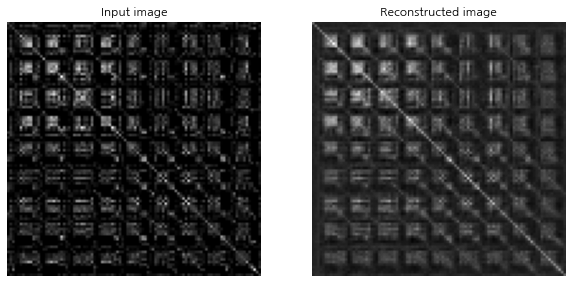

Reconstruciton error:  0.0071265497244894505


In [131]:
plt.figure(figsize = (10,8))
plt.subplot(1,2,1)
plt.imshow(test_input0[0], 'gray')
plt.title('Input image')
plt.axis('off')
plt.subplot(1,2,2)
plt.imshow(test_recon0[0], 'gray')
plt.title('Reconstructed image')
plt.axis('off')
plt.show()
print('Reconstruciton error: ', n_recon_err)

#### 원 데이터를 가지고 ERROR를 구하기

In [173]:
file_name = 'reamer.json'
with open (file_name, "r", encoding='utf-8') as f:
    reamer = json.load(f)
    
reamer = pd.DataFrame(reamer)
src = reamer['srcData']

index30000 = [[],[]]
for i in src:
    n = 0
    while i[n] < 30000:
        n = n+1
        if i[n] > 30000:
            index30000[0].append(n)
            index30000[1].append(i[n])
            
df = pd.DataFrame({'num':index30000[0],'value':index30000[1]})

for i in range(len(src)):
    src[i] = src[i][df.num[i]:]

<ipython-input-173-2e8c4c5330ef>:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src[i] = src[i][df.num[i]:]


In [174]:
src_df = pd.DataFrame({'srcData':src,'length':0})

for i in range(len(src_df)):
    src_df['length'][i] = len(src_df['srcData'][i])

for i in range(len(src)):
    src[i] = src[i][40:447]

src_df = pd.DataFrame({'srcData':src,'length':0})

for i in range(len(src_df)):
    src_df['length'][i] = len(src_df['srcData'][i])
    
src_df=src_df[src_df.length==407].reset_index(drop=True)

<ipython-input-174-2f8de6bd228d>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src_df['length'][i] = len(src_df['srcData'][i])
<ipython-input-174-2f8de6bd228d>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src[i] = src[i][40:447]
<ipython-input-174-2f8de6bd228d>:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  src_df['length'][i] = len(src_df['srcData'][i])


In [223]:
src_df

,srcData,length
0,"[1447, 1293, 1234, 1246, 1313, 1430, 1588, 175...",407
1,"[2294, 1786, 1500, 1357, 1316, 1344, 1424, 154...",407
2,"[1807, 1509, 1358, 1309, 1334, 1414, 1541, 170...",407
3,"[1950, 1598, 1413, 1344, 1355, 1426, 1547, 170...",407
4,"[1706, 1463, 1353, 1334, 1381, 1483, 1631, 180...",407
...,...,...
22976,"[1179, 1107, 1106, 1161, 1260, 1397, 1552, 168...",407
22977,"[1125, 1103, 1141, 1225, 1351, 1504, 1648, 175...",407
22978,"[1140, 1102, 1132, 1213, 1337, 1493, 1650, 176...",407
22979,"[1123, 1118, 1173, 1275, 1418, 1577, 1709, 179...",407


In [178]:
Realdata = dict(src_df.srcData)
Realdata_array = np.array(list(Realdata.values()), dtype = object)
Realdata = mms.fit_transform(Realdata_array.reshape(len(Realdata), 407))
Realdata

array([[0.13383907, 0.13729683, 0.19815668, ..., 0.07188114, 0.06328676,
        0.05502976],
       [0.36331617, 0.34816082, 0.37327189, ..., 0.07856675, 0.07159233,
        0.06256691],
       [0.23137361, 0.22968349, 0.27978934, ..., 0.07292987, 0.06393563,
        0.05528671],
       ...,
       [0.05066378, 0.05560308, 0.13100724, ..., 0.07743063, 0.06869403,
        0.05884116],
       [0.04605798, 0.06244654, 0.15799868, ..., 0.07131309, 0.06151317,
        0.05254593],
       [0.05608236, 0.05859709, 0.12837393, ..., 0.07834826, 0.07012156,
        0.06034003]])

In [179]:
Real_RC = []
for i in range(len(Realdata)//100):
    SlicingSet = transformer.transform(Realdata[100*i:100*(i+1)]).astype('float32')
    for j in range(100):
        resized_image = cv2.resize(SlicingSet[j],(100, 100), interpolation=cv2.INTER_AREA)
        Real_RC.append(resized_image)

SlicingSet = transformer.transform(Realdata[-(len(Realdata)%100):]).astype('float32')
for k in range(len(Realdata)%100):
    resized_image = cv2.resize(SlicingSet[k],(100, 100), interpolation=cv2.INTER_AREA)
    Real_RC.append(resized_image)
    
Real_RC = np.array(Real_RC)

#### RC : 영일이가 분류한 정상 데이터(이미 학습에 적용함)
#### Real_RC : 기존의 원본 데이터(test에 적용해야 됨)@@@@

In [214]:
RC_test = Real_RC.reshape((Real_RC.shape[0],100*100))

scaler = MinMaxScaler()
scaler.fit(RC_test)
RC_test_scaled=scaler.transform(RC_test)

test_imgs = RC_test_scaled

In [213]:
RC_test.shape

(22981, 10000)

In [215]:
autoencoder1.evaluate(test_imgs[0:1], test_imgs[0:1], verbose = 2)

1/1 - 0s - loss: 0.0584 - mse: 0.0584


In [140]:
test_imgs[0].reshape(-1,10000).shape,        test_imgs[0:1].shape

((1, 10000), (1, 10000))

In [141]:
autoencoder1.evaluate(test_imgs[0].reshape(-1,100*100), test_imgs[0].reshape(-1,100*100), verbose = 2)

1/1 - 0s - loss: 0.0092 - mse: 0.0092


[0.009195650927722454, 0.009195650927722454]

In [217]:
Test_score = list()
Test_score.append(test_scores1)

In [218]:
Test_score

[[0.058400221168994904, 0.058400221168994904]]

In [219]:
Test_score = list()

for i in range(len(test_imgs)):
    Test_score.append(autoencoder1.evaluate(test_imgs[i].reshape(-1,100*100), test_imgs[i].reshape(-1,100*100), verbose = 2)[0])

1/1 - 0s - loss: 0.0584 - mse: 0.0584
1/1 - 0s - loss: 0.0575 - mse: 0.0575
1/1 - 0s - loss: 0.0575 - mse: 0.0575
1/1 - 0s - loss: 0.0505 - mse: 0.0505
1/1 - 0s - loss: 0.0546 - mse: 0.0546
1/1 - 0s - loss: 0.0554 - mse: 0.0554
1/1 - 0s - loss: 0.0541 - mse: 0.0541
1/1 - 0s - loss: 0.0557 - mse: 0.0557
1/1 - 0s - loss: 0.0565 - mse: 0.0565
1/1 - 0s - loss: 0.0549 - mse: 0.0549
1/1 - 0s - loss: 0.0544 - mse: 0.0544
1/1 - 0s - loss: 0.0588 - mse: 0.0588
1/1 - 0s - loss: 0.0586 - mse: 0.0586
1/1 - 0s - loss: 0.0588 - mse: 0.0588
1/1 - 0s - loss: 0.0598 - mse: 0.0598
1/1 - 0s - loss: 0.0583 - mse: 0.0583
1/1 - 0s - loss: 0.0639 - mse: 0.0639
1/1 - 0s - loss: 0.0572 - mse: 0.0572
1/1 - 0s - loss: 0.0620 - mse: 0.0620
1/1 - 0s - loss: 0.0593 - mse: 0.0593
1/1 - 0s - loss: 0.0565 - mse: 0.0565
1/1 - 0s - loss: 0.0582 - mse: 0.0582
1/1 - 0s - loss: 0.0578 - mse: 0.0578
1/1 - 0s - loss: 0.0572 - mse: 0.0572
1/1 - 0s - loss: 0.0575 - mse: 0.0575
1/1 - 0s - loss: 0.0595 - mse: 0.0595
1/1 - 0s - l

In [220]:
len(Test_score)

22980

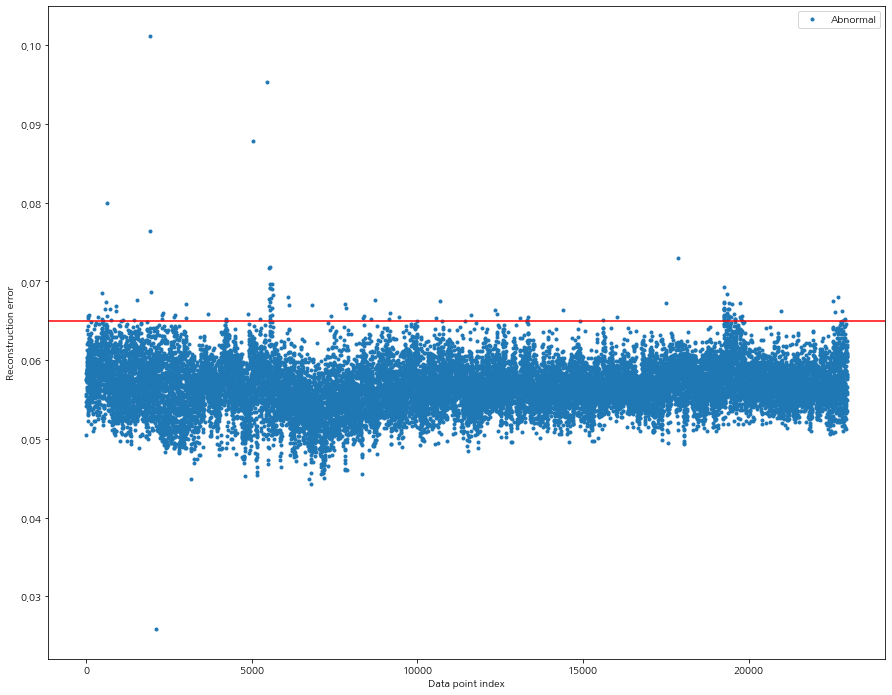

In [222]:
threshold = 0.065

plt.figure(figsize = (15, 12))
plt.plot(Test_score, '.', label = 'Abnormal')
plt.xlabel('Data point index')
plt.ylabel('Reconstruction error')
plt.axhline(y=threshold, color='r', linestyle='-')
plt.legend()
plt.show()